In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

In [ ]:
# Device Configuration
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Adjust Model Structure Depends on the Data
num_classes = 10 # label 0~9: total 10 classes
in_channel = 3 # black and white images: 1 channel (RGB: 3 channels)

# Hyper-parameters
batch_size = 10
max_pool_kernel = 2
learning_rate = 0.001
num_epochs = 30

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 32, 32])
cat


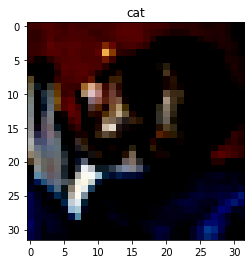

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torchsummary as summary
#from scipy.misc import toimage


print(testset[0][0].shape)
print(classes[testset[0][-1]])
plt.figure(figsize=(4,4))
plt.imshow(np.transpose(testset[0][0], (1, 2, 0)), interpolation='nearest')
plt.title(classes[testset[0][-1]])
plt.show()

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(3,6,(5,5)),
        nn.BatchNorm2d(6),
        nn.ReLU(),
        nn.MaxPool2d(2,stride=2)
    )
    self.layer2 = nn.Sequential(
        nn.Conv2d(6,16,(5,5)),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.MaxPool2d(2,stride=2)
    )
    self.layer3= nn.Linear(5*5*16, 120)
    self.layer4 = nn.Linear(120, 84)
    self.fc=nn.Linear(84,10)

  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = out.reshape(out.size(0),-1)
    out = F.relu(self.layer3(out)) #layer 3
    out = self.layer4(out)
    out = self.fc(out)

    return out

model = Net()

In [ ]:
print(model)
#model = Net().to(device)

Net(
  (layer1): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Linear(in_features=400, out_features=120, bias=True)
  (layer4): Linear(in_features=120, out_features=84, bias=True)
  (fc): Linear(in_features=84, out_features=10, bias=True)
)


In [ ]:
# cf) see network form
print(model)

# cf) check the number of parameters
print('{:=^60}'.format("="))
print('{:^60}'.format("model summary"))
print('{:=^60}'.format("="))
for param_tensor in model.state_dict():
  print('%-30s'%param_tensor, '{:^30}'.format(str(model.state_dict()[param_tensor].size())))
print('{:=^60}'.format("="))

Net(
  (layer1): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Linear(in_features=400, out_features=120, bias=True)
  (layer4): Linear(in_features=120, out_features=84, bias=True)
  (fc): Linear(in_features=84, out_features=10, bias=True)
)
                       model summary                        
layer1.0.weight                   torch.Size([6, 3, 5, 5])   
layer1.0.bias                         torch.Size([6])        
layer1.1.weight                       torch.Size([6])        
layer1.1.b

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
total_step = len(trainloader)
loss_list = []
# Train
for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(trainloader):
    # Assign Tensors to Configured Device
    #images = images.to(device)
    #labels = labels.to(device)

    # Forward Propagation
    outputs = model(images)

    # Get Loss, Compute Gradient, Update Parameters
    loss = criterion(outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Append loss to plot graph
    loss_list.append(loss)

    # Print Loss for Tracking Training
    if i % 2000 == 0:
      acc = 0
      test_image, test_label = next(iter(testloader))
      _, test_predicted = torch.max(model(test_image).data, 1)

      for (pred, ans) in zip(test_predicted, test_label):
        if pred == ans:
          acc += 1
      acc = acc / len(test_predicted)
      print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.1f}%'.format(epoch+1,num_epochs, i+1, total_step, loss.item(), acc*100))
      print('Testing data: [Predicted: {} / Real: {}]'.format(test_predicted, test_label))

  if epoch+1 == num_epochs:
    torch.save(model.state_dict(), 'model.pth')
  else:
    torch.save(model.state_dict(), 'model-{:02d}_epochs.pth'.format(epoch+1))

Epoch [1/30], Step [1/5000], Loss: 2.3104, Accuracy: 0.0%
Testing data: [Predicted: tensor([0, 0, 0, 2, 0, 0, 0, 9, 0, 2]) / Real: tensor([3, 8, 8, 0, 6, 6, 1, 6, 3, 1])]
Epoch [1/30], Step [2001/5000], Loss: 1.8061, Accuracy: 40.0%
Testing data: [Predicted: tensor([3, 0, 9, 0, 4, 6, 5, 6, 5, 9]) / Real: tensor([3, 8, 8, 0, 6, 6, 1, 6, 3, 1])]
Epoch [1/30], Step [4001/5000], Loss: 2.2651, Accuracy: 60.0%
Testing data: [Predicted: tensor([3, 1, 9, 0, 6, 6, 5, 6, 5, 1]) / Real: tensor([3, 8, 8, 0, 6, 6, 1, 6, 3, 1])]
Epoch [2/30], Step [1/5000], Loss: 0.9882, Accuracy: 50.0%
Testing data: [Predicted: tensor([3, 8, 0, 8, 4, 6, 4, 6, 5, 1]) / Real: tensor([3, 8, 8, 0, 6, 6, 1, 6, 3, 1])]
Epoch [2/30], Step [2001/5000], Loss: 1.2475, Accuracy: 70.0%
Testing data: [Predicted: tensor([3, 0, 0, 0, 6, 6, 1, 6, 7, 1]) / Real: tensor([3, 8, 8, 0, 6, 6, 1, 6, 3, 1])]
Epoch [2/30], Step [4001/5000], Loss: 1.2384, Accuracy: 60.0%
Testing data: [Predicted: tensor([3, 8, 9, 0, 4, 6, 6, 6, 5, 1]) / Rea

In [ ]:
# Test after training is done
model.eval() # Set model as evaluation mode (instead of mini-batch mean/var, batchnorm is used)
with torch.no_grad(): # auto_grad off
  correct = 0
  total = 0
  for images, labels in testloader:
    #images = images.to(device)
    #labels = labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  print('Accuracy of the network on the {} test images {}%'.format(len(testloader)*batch_size, 100*correct/total))

Accuracy of the network on the 10000 test images 65.16%


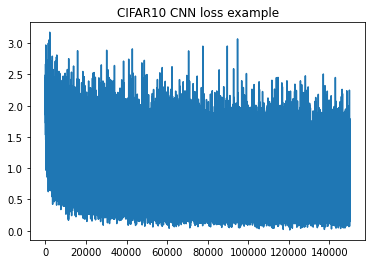

In [ ]:
plt.plot(loss_list)
plt.title("CIFAR10 CNN loss example")
plt.show()